In [2]:
import numpy as np
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()

In [3]:
example["frames"].shape

(91, 400)

In [4]:
example["samples"].shape

(18432,)

In [5]:
400*91

36400

In [6]:
data = np.load('lab1_data.npz', allow_pickle=True)['data']
data

array([{'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav', 'samplingrate': 20000, 'gender': 'man', 'speaker': 'bm', 'digit': 'o', 'repetition': 'a', 'samples': array([-2, -1, -3, ..., 10,  8,  5], dtype=int16)},
       {'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/ob.wav', 'samplingrate': 20000, 'gender': 'man', 'speaker': 'bm', 'digit': 'o', 'repetition': 'b', 'samples': array([  0,   0,   4, ..., -14, -12, -11], dtype=int16)},
       {'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/za.wav', 'samplingrate': 20000, 'gender': 'man', 'speaker': 'bm', 'digit': 'z', 'repetition': 'a', 'samples': array([-1,  0, -3, ...,  0,  0, -2], dtype=int16)},
       {'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/zb.wav', 'samplingrate': 20000, 'gender': 'man', 'speaker': 'bm', 'digit': 'z', 'repetition': 'b', 'samples': array([ 1, -1, -4, ...,  8,  9,  9], dtype=int16)},
       {'filen

## enframe

In [7]:
def enframe(samples, winlen, winshift):
    """
    Slices the input samples into overlapping windows.

    Args:
        winlen: window length in samples.
        winshift: shift of consecutive windows in samples
    Returns:
        numpy array [N x winlen], where N is the number of windows that fit
        in the input signal
    """
    n_frames = ((samples.size - winlen) // winshift) + 1
    output = np.zeros((n_frames,winlen))
    for i in range(0, n_frames):
        output[i] = samples[i*winshift:i*winshift+winlen]
    return output

In [8]:
out=enframe(example["samples"],400,200)
out.shape

(91, 400)

In [9]:
np.sum(out!=example["frames"])

0

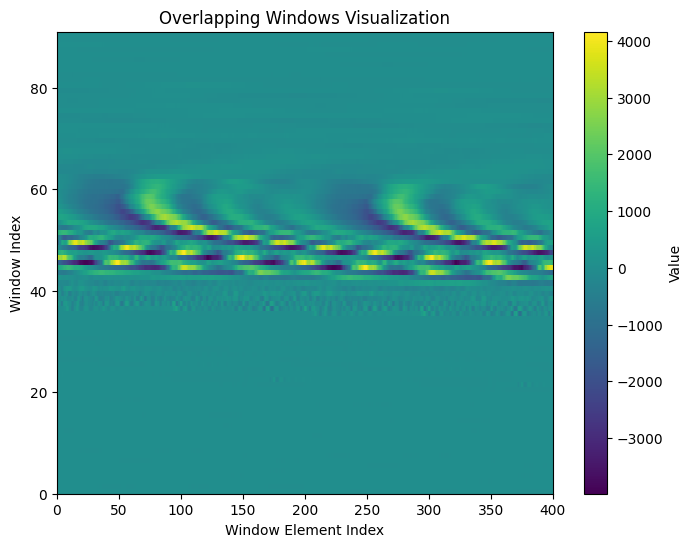

In [10]:
import matplotlib.pyplot as plt
def plot(data):
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(data, cmap='viridis')
    plt.colorbar(label='Value')
    plt.xlabel('Window Element Index')
    plt.ylabel('Window Index')
    plt.title('Overlapping Windows Visualization')
    plt.show()
plot(out)

## pre-emphasis

In [11]:
from scipy.signal import lfilter
def preemp(frames, alpha=0.97):
    """
    Applies a pre-emphasis filter to each frame.

    Args:
        frames: 2D numpy array of frames from enframe function.
        alpha: Pre-emphasis coefficient.
    Returns:
        A 2D numpy array with the filtered frames.
    """
    b = [1, -alpha]  # Numerator coefficients
    a = [1]  # Denominator coefficients
    return np.array([lfilter(b, a, frame) for frame in frames])

In [12]:
np.sum(preemp(enframe(example["samples"],400,200))!=example["preemph"])

0

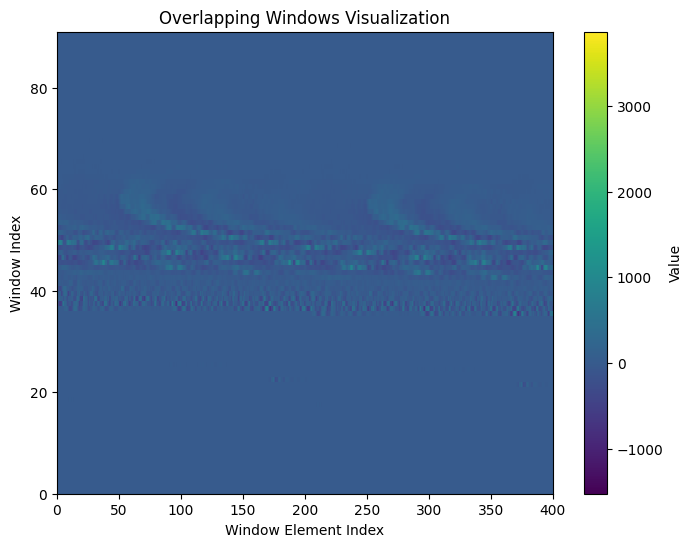

In [13]:
plot(preemp(enframe(example["samples"],400,200)))

## hamming window

In [14]:
from scipy.signal import hamming
# Function to apply a Hamming window to each frame
def apply_window(frames, sym=False):
    """
    Applies a Hamming window to each frame.

    Args:
        frames: 2D numpy array of frames.
        sym: When False (default), generates a periodic window, suitable for spectral analysis.
    Returns:
        A 2D numpy array with the windowed frames.
    """
    num_samples = frames.shape[1]  # Number of samples in each frame
    hamming_window = hamming(num_samples, sym=sym)
    return frames * hamming_window

In [15]:
ham=apply_window(preemp(enframe(example["samples"],400,200)))

C:\Users\A\AppData\Local\Temp\ipykernel_20960\3862623682.py:14: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  hamming_window = hamming(num_samples, sym=sym)


In [16]:
np.allclose(ham,example['windowed'])

True

## FFT

In [17]:
from scipy.fftpack import fft
def powerSpectrum(frames, NFFT=512):
    """
    Computes the power spectrum of each frame in frames.

    Args:
        frames: 2D numpy array of windowed frames from the speech signal.
        NFFT: The FFT length.
        
    Returns:
        A 2D numpy array where each row represents the power spectrum of a frame.
    """
    # Compute the FFT and then calculate the squared modulus (power spectrum) of the FFT result
    fft_frames = fft(frames, n=NFFT)
    power_spec = np.abs(fft_frames) ** 2
    # Return only the first half of each FFT, as it's symmetric and represents the positive frequencies
    return power_spec#[:, :NFFT // 2 + 1]

In [18]:
np.allclose(powerSpectrum(ham),example['spec'])

True

## Mel filterbank log spectrum

In [19]:
from lab1_tools import trfbank
def logMelSpectrum(power_spectrum, sampling_frequency, nfft):
    """
    Applies a mel filterbank to the power spectrum and computes the logarithm of the filterbank energies.

    Args:
        power_spectrum: 2D numpy array of the power spectrum of the speech frames.
        sampling_rate: The sampling rate of the speech signal.
        

    Returns:
        A 2D numpy array where each row represents the log Mel spectrum of a frame.
    """
    # Create the triangular filterbank
    fbank = trfbank(sampling_frequency,nfft)
    
    # Apply the filters to the power spectrum
    mspec = np.log(np.dot(power_spectrum, fbank.T))
    
    return mspec

In [20]:
logmel = logMelSpectrum(powerSpectrum(ham),example["samplingrate"],512)

In [21]:
np.allclose(logmel,example['mspec'])

True

## Cosine Transofrm and Liftering

In [22]:
from scipy.fftpack.realtransforms import dct
from lab1_tools import lifter  # Make sure to import the lifter function correctly

def cepstrum(input, nceps):
    """
    Calculates Cepstral coefficients from mel spectrum applying Discrete Cosine Transform (DCT).

    Args:
        input: 2D numpy array of log outputs of Mel scale filterbank [N x nmelfilters], where N is the
               number of frames and nmelfilters the length of the filterbank.
        nceps: Number of output cepstral coefficients.

    Returns:
        2D numpy array of Cepstral coefficients [N x nceps].
    """
    # Apply DCT to the mel-spectrum input
    cepstral_coeffs = dct(input)
    
    # Select the first 'nceps' coefficients
    cepstral_coeffs = cepstral_coeffs[:, :nceps]
    
    return cepstral_coeffs

C:\Users\A\AppData\Local\Temp\ipykernel_20960\3803375123.py:1: DeprecationWarning: Please use `dct` from the `scipy.fftpack` namespace, the `scipy.fftpack.realtransforms` namespace is deprecated.
  from scipy.fftpack.realtransforms import dct


In [23]:
nceps = 13
np.allclose(cepstrum(logmel, nceps),example['mfcc'])

True

In [24]:
# Apply liftering
lft = lifter(cepstrum(logmel, nceps), 22)  # Example liftering parameter L=22, adjust as needed
np.allclose(lft,example["lmfcc"])

True

## test mfcc function and mspec function

In [25]:
from lab1_proto import mspec,mfcc
m=mspec(example["samples"])
np.allclose(cepstrum(m,13),example["mfcc"])

True

In [26]:
np.allclose(mfcc(example["samples"]),example["lmfcc"])

True

## 5

In [27]:
# calculate total number of frames in dataset
mfcc_list = []
M = 13
for datapoint in data:
    mfcc_list.append(mfcc(datapoint["samples"],nceps=M))

In [28]:
# calculate N
N = 0
for i in mfcc_list:
    N+=i.shape[0]
N

3885

In [29]:
X = np.concatenate(mfcc_list, axis=0) # N x M
X.shape

(3885, 13)

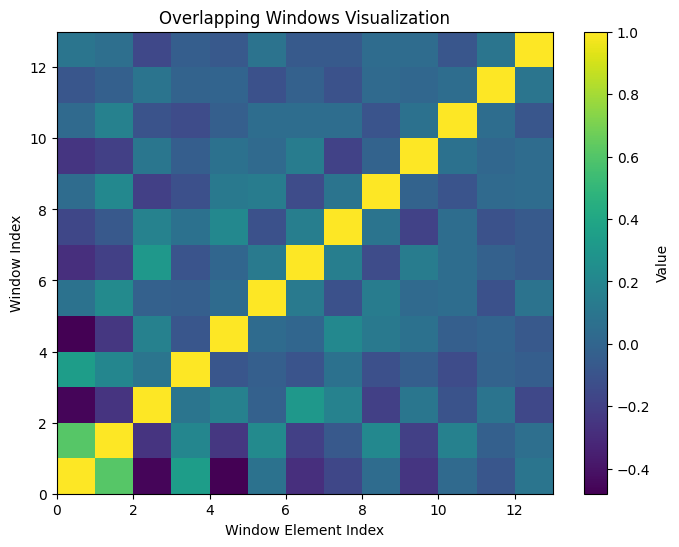

In [30]:
#calculate correlational coefficient
C = np.corrcoef(X.T)
plot(C)

In [31]:
#compare with Mel filterbank features
mspec_list = []
M_mel = 13
for datapoint in data:
    mspec_list.append(mspec(datapoint["samples"]))
# calculate N
N_mel = 0
for i in mspec_list:
    N_mel+=i.shape[0]
X_mel = np.concatenate(mspec_list, axis=0) # N x M
X_mel.shape

(3885, 40)

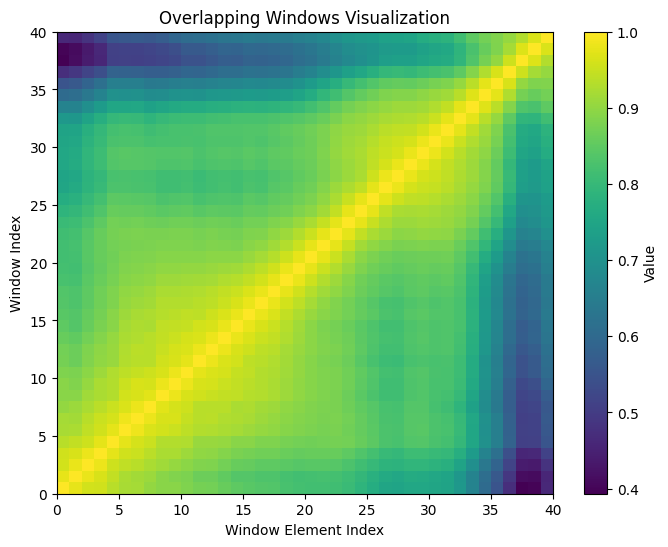

In [32]:
C_mel = np.corrcoef(X_mel.T)
plot(C_mel)

## 6

In [33]:
from sklearn.mixture import GaussianMixture

# Define the number of components for GMMs
components = [4, 8, 16, 32]

# Train GMMs
gmms = [GaussianMixture(n_components=n, covariance_type='diag').fit(X) for n in components]


In [34]:
data[0]

{'filename': '/home/giampi/corpora/tidigits/disc_4.2.1/tidigits/test/man/bm/oa.wav',
 'samplingrate': 20000,
 'gender': 'man',
 'speaker': 'bm',
 'digit': 'o',
 'repetition': 'a',
 'samples': array([-2, -1, -3, ..., 10,  8,  5], dtype=int16)}

In [35]:
#create a list of utterances
from collections import defaultdict

# Initialize a dictionary to hold the lists of indices for each digit (class)
class_indices = defaultdict(list)

# Iterate through the dataset and populate the dictionary
for index, item in enumerate(data):
    digit_class = item['digit']
    class_indices[digit_class].append(index)

# Convert defaultdict to a regular dict for display purposes
class_indices = dict(class_indices)

# Print the class indices to verify
for digit, indices in class_indices.items():
    print(f"Class '{digit}': {indices}")


Class 'o': [0, 1, 22, 23]
Class 'z': [2, 3, 24, 25]
Class '1': [4, 5, 26, 27]
Class '2': [6, 7, 28, 29]
Class '3': [8, 9, 30, 31]
Class '4': [10, 11, 32, 33]
Class '5': [12, 13, 34, 35]
Class '6': [14, 15, 36, 37]
Class '7': [16, 17, 38, 39]
Class '8': [18, 19, 40, 41]
Class '9': [20, 21, 42, 43]


In [39]:
len(mfcc_list)

44

In [60]:
# Assuming 'utterance_features' is a list of arrays, each containing features for a specific utterance
utterance_ids = class_indices["7"]
utterance_features = [mfcc_list[i] for i in utterance_ids]  # Replace mfcc_features with your data structure

# Compute GMM posteriors for the chosen utterance using the model with 32 components
model_32 = gmms[-1]  # Assuming the last model is the one with 32 components
posteriors = [model_32.predict_proba(features) for features in utterance_features]


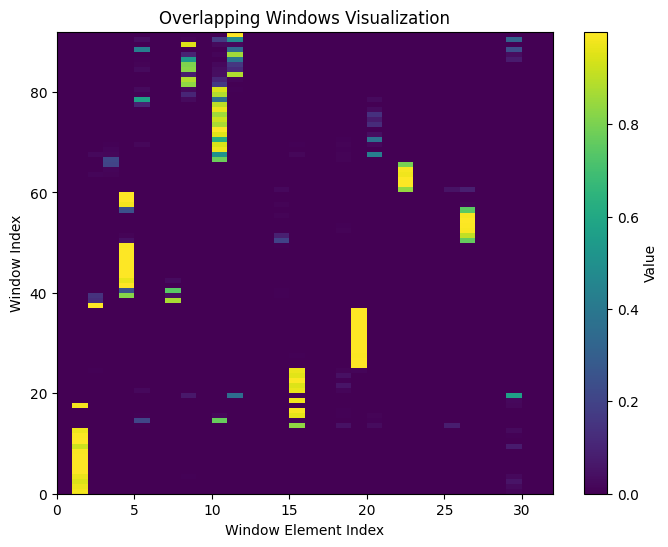

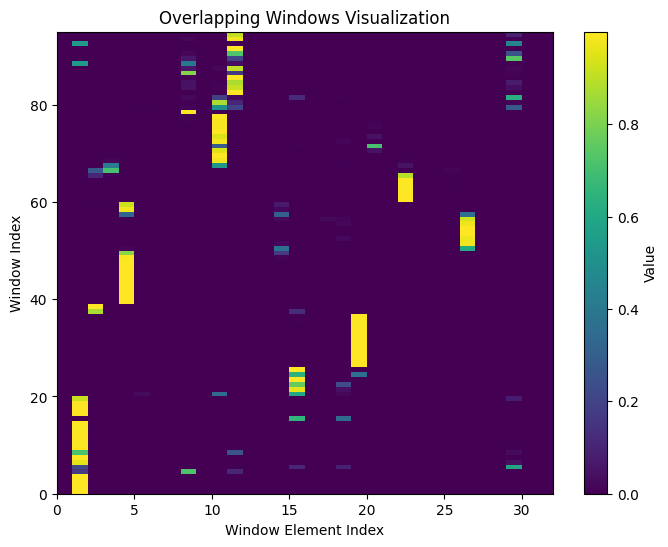

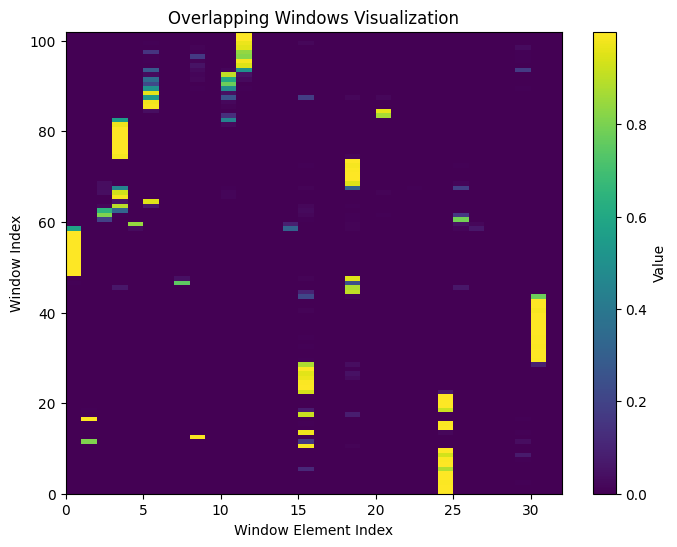

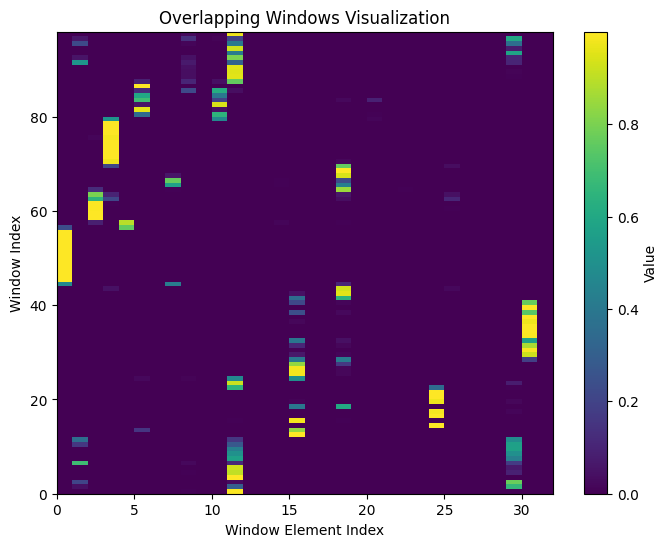

In [58]:
for posterior in posteriors:
    plot(posterior)

In [52]:
[print(f"{np.round(i,2)}\n)") for i in posteriors]

[[0.   0.98 0.   ... 0.01 0.   0.  ]
 [0.   0.97 0.   ... 0.03 0.   0.  ]
 [0.   0.95 0.   ... 0.05 0.   0.  ]
 ...
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.31 0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]
)
[[0.   1.   0.   ... 0.   0.   0.  ]
 [0.   1.   0.   ... 0.   0.   0.  ]
 [0.   1.   0.   ... 0.   0.   0.  ]
 ...
 [0.   0.54 0.   ... 0.45 0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.   ... 0.09 0.   0.  ]]
)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
)
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.   0.04 0.   ... 0.66 0.   0.  ]
 [0.   0.2  0.   ... 0.77 0.   0.  ]
 ...
 [0.   0.22 0.   ... 0.36 0.   0.  ]
 [0.   0.06 0.   ... 0.59 0.   0.  ]
 [0.   0.   0.   ... 0.   0.   0.  ]]
)


[None, None, None, None]

## 7

In [76]:
# compute euclidean distance
def pairwise_euclidean_distance(mfcc_mat_1,mfcc_mat_2):
    """
    Computes an N x M matrix of euclidean distances between each MFCC vectors

    Args:
        mfcc_mat_1: N x d i.e. N windows
        mfcc_mat_2: M x d i.e. M windows
    """
    N = mfcc_mat_1.shape[0]
    M = mfcc_mat_2.shape[0]
    output = np.zeros((N,M))
    for n in range(N):
        for m in range(M):
            output[n,m] = np.linalg.norm(mfcc_mat_1[n]-mfcc_mat_2[m])
    return output


In [70]:
pairwise_euclidean_distance(mfcc_list[0],mfcc_list[1]).shape

(82, 74)

In [93]:
def dtw_distance(matrix):
    N, M = matrix.shape
    dtw_matrix = np.full((N+1, M+1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in range(1, N+1):
        for j in range(1, M+1):
            cost = matrix[i-1, j-1]
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j],    # insertion
                                          dtw_matrix[i, j-1],    # deletion
                                          dtw_matrix[i-1, j-1])  # match
    #global distance between the two sequences
    #i.e minimum cumulative distance required to align the two sequences. 
    return dtw_matrix[N, M]

For each pair of utterances in the data array:

In [80]:
len(mfcc_list)

44

In [94]:
D = np.zeros((len(mfcc_list),len(mfcc_list)))
for i in range(len(mfcc_list)):
    for j in range(len(mfcc_list)):
        local_dist_matrix = pairwise_euclidean_distance(mfcc_list[i],mfcc_list[j])
        D[i,j] = dtw_distance(local_dist_matrix)


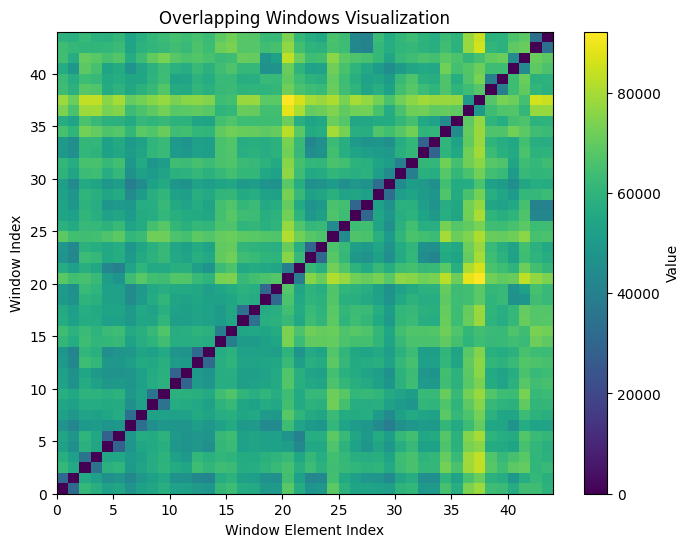

In [95]:
plot(D)

In [ ]:
D = np.zeros((len(mfcc_list),len(mfcc_list)))
for i in range(len(mfcc_list)):
    for j in range(len(mfcc_list)):
        local_dist_matrix = pairwise_euclidean_distance(mfcc_list[i],mfcc_list[j])
        D = dtw_distance(local_dist_matrix)

hierarchical clustering

C:\Users\A\AppData\Local\Temp\ipykernel_20960\892877974.py:4: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(D, method='complete')


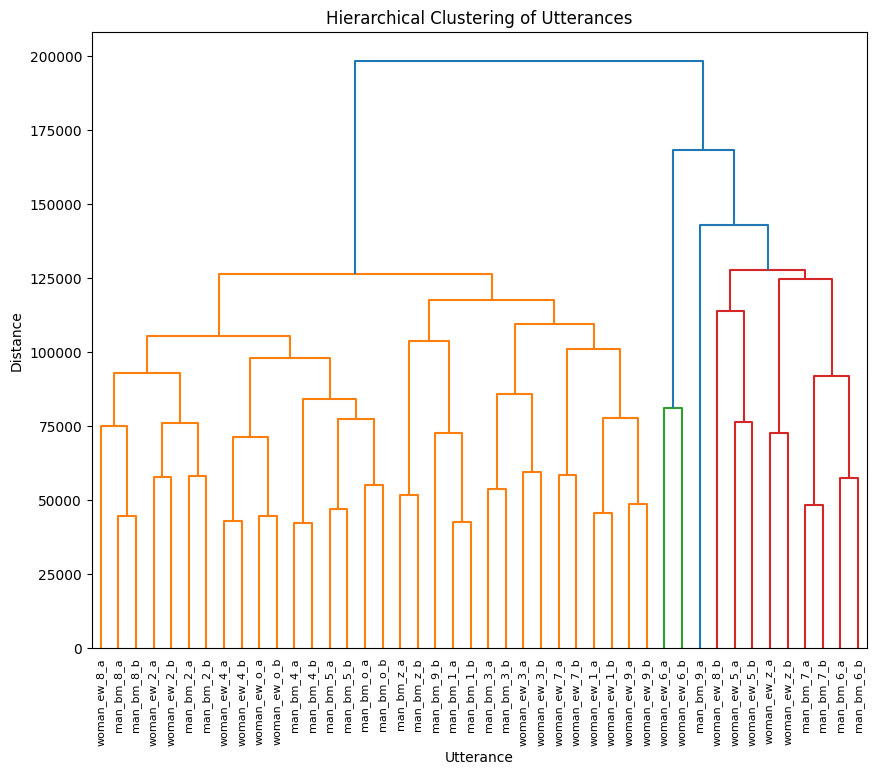

In [98]:
from scipy.cluster.hierarchy import dendrogram, linkage
from lab1_tools import tidigit2labels
# Run hierarchical clustering
Z = linkage(D, method='complete')

# Plot dendrogram
plt.figure(figsize=(10, 8))
dendrogram(Z, labels=tidigit2labels(data), leaf_rotation=90)
plt.title('Hierarchical Clustering of Utterances')
plt.xlabel('Utterance')
plt.ylabel('Distance')
plt.show()